This is a demo of

# Backward Modeling of Imaging Systematics in Galaxy Surveys

The main methodology is described in Rezaie et al. 2019. This notebook is going to repackage the pipeline that is in https://github.com/mehdirezaie/SYSNet. The main idea is that a feed forward neural network is trained to learn the effect of imaging quantities such as seeing, airmass, stellar density on the photometric images, photometric targets.

## modules
`regression` has the implementation of the neural networks, while `selection` has the implementation of the backward feature elimination/selection.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time


import sys
import os
home = os.getenv("HOME")
sys.path.append(f'{home}/github/LSSutils')


import regression   # for regression
import selection    # for feature selection
from LSSutils import setup_logging

In [4]:
setup_logging('info')

## example of eBOSS QSOs

Things to add                  
1. Read Galaxy and Random catalogs, RA, DEC, Z, Weight                  
2. Condense them into surface density, completeness
3. Read, Add Imaging Templates and make them a pandas df
4. Split the dataset on the fly for k-fold validation
5. Train, validation, and test ... aggregate the results
6. Export the result as a weight map & per-object file

[ 000339.16 ]   0: 01-28 23:09  NetRegression   INFO     Scale features and label
[ 000339.24 ]   0: 01-28 23:09  NetRegression   INFO     chain-0 with seed : 3391302632


.............

[ 000343.94 ]   0: 01-28 23:09  NetRegression   INFO     done in 4.6 secs


.

[ 000345.45 ]   0: 01-28 23:09  NetRegression   INFO     Test LOSS : 0.719 MAE : 0.682 MSE : 1.016
[ 000345.45 ]   0: 01-28 23:09  NetRegression   INFO     Baseline test MSE : 1.016
[ 000345.45 ]   0: 01-28 23:09  NetRegression   INFO     Variance of the test label : 1.016
[ 000345.45 ]   0: 01-28 23:09  NetRegression   INFO     Total val loss : 0.7172231979534437


<Figure size 864x0 with 0 Axes>

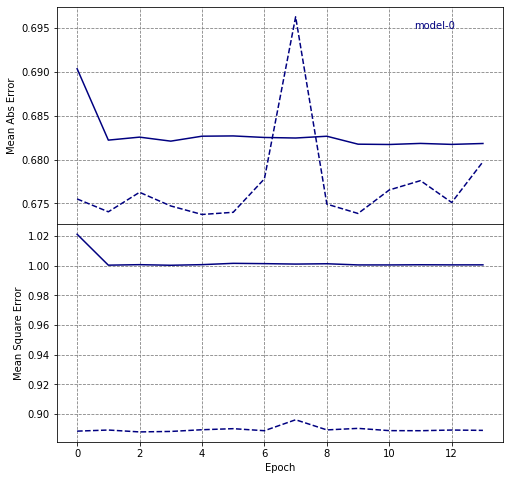

took 6.973292112350464 secs


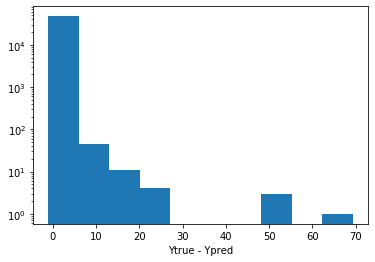

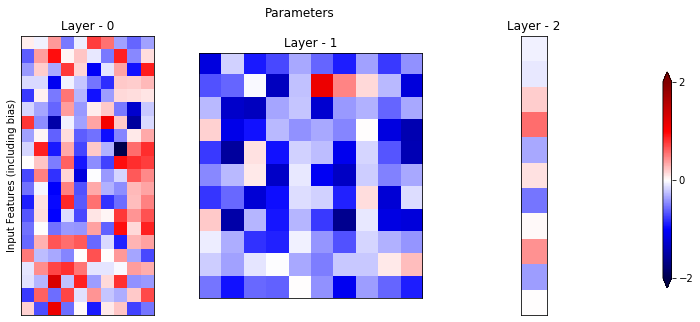

In [7]:
data  = np.load('/Users/mehdi/Downloads/ngal_features_NGC_all_512.5r.npy', allow_pickle=True).item()
train = regression.Data(data['train']['fold0'])
valid = regression.Data(data['validation']['fold0'])
test  = regression.Data(data['test']['fold0'])



t_i = time.time()
Net = regression.NetRegression(train, valid, test)
Net.fit(predict=True, min_delta=1.e-8,
        batch_size=1024, units=[10, 10],
        learning_rate=0.1)
Net._descale() # descale
Net.make_plots()
t_f = time.time()
print(f'took {t_f-t_i} secs')

In [7]:
#-- start from all indices
train = regression.Data(data['train']['fold0'],      cachex=True)
valid = regression.Data(data['validation']['fold0'], cachex=True)
test  = regression.Data(data['test']['fold0'],       cachex=True)

FE    = selection.FeatureElimination(train, valid, test)

In [9]:
FE([0, 1 ,2])

[ 000045.44 ]   0: 12-20 10:36  FeatureElimination INFO     Perform Feature Selection with [0, 1, 2]
[ 000045.45 ]   0: 12-20 10:36  NetRegression   INFO     Scale features and label
[ 000045.46 ]   0: 12-20 10:36  NetRegression   INFO     chain-0 with seed : 3391302632


....................

[ 000047.30 ]   0: 12-20 10:36  NetRegression   INFO     done in 1.7 secs
[ 000047.30 ]   0: 12-20 10:36  NetRegression   INFO     Total val loss : 0.6844106853941896
[ 000047.30 ]   0: 12-20 10:36  NetRegression   INFO     Scale features and label
[ 000047.31 ]   0: 12-20 10:36  NetRegression   INFO     chain-0 with seed : 3391302632


....................

[ 000049.09 ]   0: 12-20 10:36  NetRegression   INFO     done in 1.7 secs
[ 000049.09 ]   0: 12-20 10:36  NetRegression   INFO     Total val loss : 0.6846293662072014
[ 000049.09 ]   0: 12-20 10:36  NetRegression   INFO     Scale features and label
[ 000049.10 ]   0: 12-20 10:36  NetRegression   INFO     chain-0 with seed : 3391302632


......................

[ 000050.74 ]   0: 12-20 10:36  NetRegression   INFO     done in 1.6 secs
[ 000050.74 ]   0: 12-20 10:36  NetRegression   INFO     Total val loss : 0.6844244615164848
[ 000050.74 ]   0: 12-20 10:36  FeatureElimination INFO     attribute index-0 with 0.6844106853941896
[ 000050.74 ]   0: 12-20 10:36  FeatureElimination INFO     Perform Feature Selection with [1, 2]
[ 000050.74 ]   0: 12-20 10:36  NetRegression   INFO     Scale features and label
[ 000050.75 ]   0: 12-20 10:36  NetRegression   INFO     chain-0 with seed : 3391302632


.....................

[ 000052.33 ]   0: 12-20 10:36  NetRegression   INFO     done in 1.5 secs
[ 000052.33 ]   0: 12-20 10:36  NetRegression   INFO     Total val loss : 0.6846183372054921
[ 000052.33 ]   0: 12-20 10:36  NetRegression   INFO     Scale features and label
[ 000052.34 ]   0: 12-20 10:36  NetRegression   INFO     chain-0 with seed : 3391302632


.................................

[ 000055.65 ]   0: 12-20 10:36  NetRegression   INFO     done in 3.2 secs
[ 000055.65 ]   0: 12-20 10:36  NetRegression   INFO     Total val loss : 0.6844144350226419
[ 000055.66 ]   0: 12-20 10:36  FeatureElimination INFO     attribute index-1 with 0.6844144350226419


..

In [10]:
FE.results

{'validmin': [[0.6844106853941896, 0.6846293662072014, 0.6844244615164848],
  [0.6846183372054921, 0.6844144350226419]],
 'importance': [0, 2],
 'indices': [[0, 1, 2], [1, 2]]}

In [26]:
results

{'validmin': [[0.6844106853941896, 0.6846293662072014, 0.6844244615164848],
  [0.6846183372054921, 0.6844144350226419]],
 'importance': [0, 2],
 'indices': [[0, 1, 2], [1, 2]]}

## example of Sin function

[ 000451.24 ]   0: 01-28 23:11  NetRegression   INFO     Scale features and label
[ 000451.25 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


.................................................................................................................................

[ 000453.68 ]   0: 01-28 23:11  NetRegression   INFO     done in 2.3 secs
[ 000453.68 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.004893622826784849
[ 000453.68 ]   0: 01-28 23:11  NetRegression   INFO     start hyperparameter training with {'learning_rate': 0.01, 'batch_size': 256, 'nepochs': 500, 'nchain': 1, 'units': [20, 20], 'scale': 0.0, 'patience': 10, 'min_delta': 1e-05, 'global_seed': 123567, 'model_dir': 'model/', 'save_model': False}
[ 000453.69 ]   0: 01-28 23:11  NetRegression   INFO     training with units : [40]
[ 000453.71 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


.....................................

[ 000455.33 ]   0: 01-28 23:11  NetRegression   INFO     done in 1.4 secs
[ 000455.33 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.3813011050224304
[ 000455.33 ]   0: 01-28 23:11  NetRegression   INFO     training with units : [20, 20]
[ 000455.34 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


...........................................................................................................................................

[ 000457.24 ]   0: 01-28 23:11  NetRegression   INFO     done in 1.8 secs
[ 000457.24 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.004893622826784849
[ 000457.24 ]   0: 01-28 23:11  NetRegression   INFO     training with units : [20, 10, 10]
[ 000457.25 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


...............................................................................................................................

[ 000460.17 ]   0: 01-28 23:11  NetRegression   INFO     done in 2.8 secs
[ 000460.17 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.005422091577202082
[ 000460.17 ]   0: 01-28 23:11  NetRegression   INFO     training with units : [10, 10, 10, 10]
[ 000460.17 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


.....................................................................................

[ 000461.84 ]   0: 01-28 23:11  NetRegression   INFO     done in 1.5 secs
[ 000461.84 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.05274239182472229
[ 000461.84 ]   0: 01-28 23:11  NetRegression   INFO     select units : [20, 20] as the best
[ 000461.84 ]   0: 01-28 23:11  NetRegression   INFO     training with scale : 0.0001
[ 000461.85 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


.......................................................................................................................................

[ 000463.53 ]   0: 01-28 23:11  NetRegression   INFO     done in 1.5 secs
[ 000463.53 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.01415691152215004
[ 000463.53 ]   0: 01-28 23:11  NetRegression   INFO     training with scale : 0.001
[ 000463.54 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


...................................................................................................................................................................................................................................................................................................................................................

[ 000466.91 ]   0: 01-28 23:11  NetRegression   INFO     done in 3.2 secs
[ 000466.91 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.03592398762702942
[ 000466.92 ]   0: 01-28 23:11  NetRegression   INFO     training with scale : 0.01
[ 000466.93 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


.........................................................................................................................................................................................................................................

[ 000471.47 ]   0: 01-28 23:11  NetRegression   INFO     done in 4.4 secs
[ 000471.47 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.13050080835819244
[ 000471.47 ]   0: 01-28 23:11  NetRegression   INFO     training with scale : 0.1
[ 000471.48 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


................................................................................................................................................................

[ 000474.91 ]   0: 01-28 23:11  NetRegression   INFO     done in 3.3 secs
[ 000474.91 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.5443853735923767
[ 000474.92 ]   0: 01-28 23:11  NetRegression   INFO     training with scale : 1.0
[ 000474.93 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


.......................................................................................................................................................................

[ 000478.81 ]   0: 01-28 23:11  NetRegression   INFO     done in 3.5 secs
[ 000478.81 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.900741696357727
[ 000478.81 ]   0: 01-28 23:11  NetRegression   INFO     training with scale : 10
[ 000478.82 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


............................................................................................................................................................................................................................

[ 000481.43 ]   0: 01-28 23:11  NetRegression   INFO     done in 2.5 secs
[ 000481.43 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.9020035266876221
[ 000481.43 ]   0: 01-28 23:11  NetRegression   INFO     training with scale : 100
[ 000481.44 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


.........................................................................................................................................................................................................................................................................................................

[ 000485.01 ]   0: 01-28 23:11  NetRegression   INFO     done in 3.3 secs
[ 000485.01 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.8986510038375854
[ 000485.01 ]   0: 01-28 23:11  NetRegression   INFO     training with scale : 1000
[ 000485.02 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


.................................................................................................................................................................................................................................................................

[ 000487.92 ]   0: 01-28 23:11  NetRegression   INFO     done in 2.8 secs
[ 000487.92 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.9005280137062073
[ 000487.92 ]   0: 01-28 23:11  NetRegression   INFO     select scale : 0.0 as the best
[ 000487.93 ]   0: 01-28 23:11  NetRegression   INFO     training with batch_size : 128
[ 000487.94 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


..................................................................................................................

[ 000489.55 ]   0: 01-28 23:11  NetRegression   INFO     done in 1.5 secs
[ 000489.55 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.004870792385190725
[ 000489.55 ]   0: 01-28 23:11  NetRegression   INFO     training with batch_size : 256
[ 000489.56 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


.......................................................................................................................................

[ 000491.35 ]   0: 01-28 23:11  NetRegression   INFO     done in 1.7 secs
[ 000491.35 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.004893622826784849
[ 000491.35 ]   0: 01-28 23:11  NetRegression   INFO     training with batch_size : 512
[ 000491.36 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


....

[ 000493.44 ]   0: 01-28 23:11  NetRegression   INFO     done in 1.8 secs
[ 000493.44 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.41710343956947327
[ 000493.44 ]   0: 01-28 23:11  NetRegression   INFO     training with batch_size : 1024
[ 000493.45 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


..............

[ 000494.92 ]   0: 01-28 23:11  NetRegression   INFO     done in 1.3 secs
[ 000494.92 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.41710343956947327
[ 000494.93 ]   0: 01-28 23:11  NetRegression   INFO     training with batch_size : 2048
[ 000494.94 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


..............

[ 000496.06 ]   0: 01-28 23:11  NetRegression   INFO     done in 1.0 secs
[ 000496.06 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.41710343956947327
[ 000496.06 ]   0: 01-28 23:11  NetRegression   INFO     training with batch_size : 4096
[ 000496.07 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


..............

[ 000496.80 ]   0: 01-28 23:11  NetRegression   INFO     done in 0.6 secs
[ 000496.80 ]   0: 01-28 23:11  NetRegression   INFO     Total val loss : 0.41710343956947327
[ 000496.81 ]   0: 01-28 23:11  NetRegression   INFO     select batch_size : 128 as the best
[ 000496.81 ]   0: 01-28 23:11  NetRegression   INFO     final set of hyperparameters : {'learning_rate': 0.01, 'batch_size': 128, 'nepochs': 500, 'nchain': 1, 'units': [20, 20], 'scale': 0.0, 'patience': 10, 'min_delta': 1e-05, 'global_seed': 123567, 'model_dir': 'model/', 'save_model': False}
[ 000496.81 ]   0: 01-28 23:11  NetRegression   INFO     final training with {'learning_rate': 0.01, 'batch_size': 128, 'nepochs': 500, 'nchain': 5, 'units': [20, 20], 'scale': 0.0, 'patience': 10, 'min_delta': 1e-05, 'global_seed': 123567, 'model_dir': 'model/', 'save_model': False, 'predict': True}
[ 000496.81 ]   0: 01-28 23:11  NetRegression   INFO     chain-0 with seed : 3391302632


..................................................................................................................................

[ 000499.03 ]   0: 01-28 23:11  NetRegression   INFO     done in 2.1 secs
[ 000499.16 ]   0: 01-28 23:11  NetRegression   INFO     Test LOSS : 0.009 MAE : 0.060 MSE : 0.009
[ 000499.16 ]   0: 01-28 23:11  NetRegression   INFO     Baseline test MSE : 1.158
[ 000499.16 ]   0: 01-28 23:11  NetRegression   INFO     Variance of the test label : 1.154
[ 000499.16 ]   0: 01-28 23:11  NetRegression   INFO     chain-1 with seed : 2688729627


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[ 000505.27 ]   0: 01-28 23:12  NetRegression   INFO     done in 6.0 secs


..................

[ 000505.41 ]   0: 01-28 23:12  NetRegression   INFO     Test LOSS : 0.287 MAE : 0.447 MSE : 0.287
[ 000505.41 ]   0: 01-28 23:12  NetRegression   INFO     Baseline test MSE : 1.158
[ 000505.41 ]   0: 01-28 23:12  NetRegression   INFO     Variance of the test label : 1.154
[ 000505.41 ]   0: 01-28 23:12  NetRegression   INFO     chain-2 with seed : 1716448871


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[ 000511.82 ]   0: 01-28 23:12  NetRegression   INFO     done in 6.3 secs


..........

[ 000511.96 ]   0: 01-28 23:12  NetRegression   INFO     Test LOSS : 0.160 MAE : 0.317 MSE : 0.160
[ 000511.96 ]   0: 01-28 23:12  NetRegression   INFO     Baseline test MSE : 1.158
[ 000511.96 ]   0: 01-28 23:12  NetRegression   INFO     Variance of the test label : 1.154
[ 000511.97 ]   0: 01-28 23:12  NetRegression   INFO     chain-3 with seed : 3960051926


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[ 000517.13 ]   0: 01-28 23:12  NetRegression   INFO     done in 4.8 secs


.............

[ 000517.27 ]   0: 01-28 23:12  NetRegression   INFO     Test LOSS : 0.194 MAE : 0.348 MSE : 0.194
[ 000517.27 ]   0: 01-28 23:12  NetRegression   INFO     Baseline test MSE : 1.158
[ 000517.27 ]   0: 01-28 23:12  NetRegression   INFO     Variance of the test label : 1.154
[ 000517.27 ]   0: 01-28 23:12  NetRegression   INFO     chain-4 with seed : 1829331237


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[ 000521.73 ]   0: 01-28 23:12  NetRegression   INFO     done in 4.2 secs
[ 000521.86 ]   0: 01-28 23:12  NetRegression   INFO     Test LOSS : 0.192 MAE : 0.345 MSE : 0.192
[ 000521.86 ]   0: 01-28 23:12  NetRegression   INFO     Baseline test MSE : 1.158
[ 000521.86 ]   0: 01-28 23:12  NetRegression   INFO     Variance of the test label : 1.154
[ 000521.86 ]   0: 01-28 23:12  NetRegression   INFO     Total val loss : 0.8229736681096256


.....

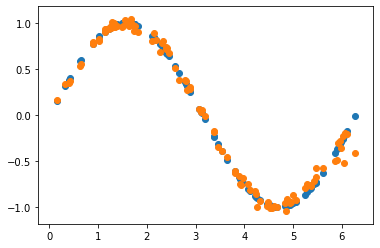

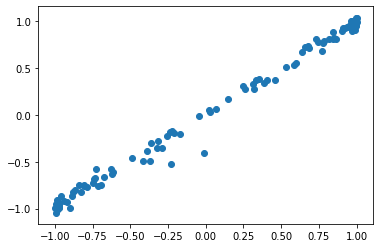

took 70.62491273880005 secs


In [9]:
import sys
sys.path.append('/Users/mehdi/github/LSSutils')
from LSSutils.utils import split2Kfolds 


def TABLE(): # create mock
    # create data
    n = 512
    np.random.seed(1234567)
    x = np.linspace(0., 2.*np.pi, n)
    z = np.random.uniform(0, 2*np.pi, size=n)
    np.random.shuffle(x) # inplace 
    y = np.sin(x) #+ 0.2*z
    #x = x[:, np.newaxis]
    x = np.column_stack([x, z])

    n,m = x.shape
    d = np.empty(n, dtype=[('label', 'f8'), 
                            ('features', ('f8', m)),
                            ('fracgood', 'f8'),
                            ('hpind', 'i8')])
    d['label'] = y
    if m==1:
        d['features']=x.squeeze()
    else:
        d['features']=x

    d['hpind']=1.
    d['fracgood']=1.0
    return d



# make table [label, features, fracgood, hpind]
Table  = TABLE()          # make table
Data5f = split2Kfolds(Table, k=5)     # split

# take one fold for example
fold   = 'fold0'
train  = regression.Data(Data5f['train'][fold])
test   = regression.Data(Data5f['test'][fold])
valid  = regression.Data(Data5f['validation'][fold])



t_i = time.time()
Net = regression.NetRegression(train, valid, test)
Net.fit(hyperparams=True)
Net._descale() # descale
#Net.make_plots()
t_f = time.time()

plt.figure()
plt.scatter(test.x[:,0], test.y)
plt.scatter(test.x[:,0], Net.ypreds[0]);plt.show()
plt.scatter(test.y, Net.ypreds[0]);plt.show()
print(f'took {t_f-t_i} secs')

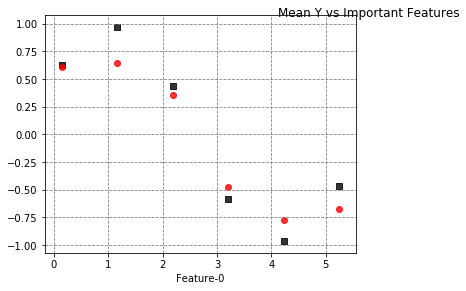

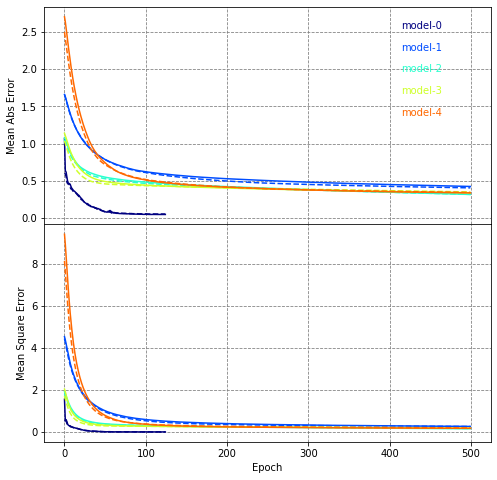

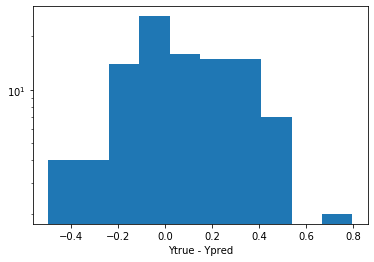

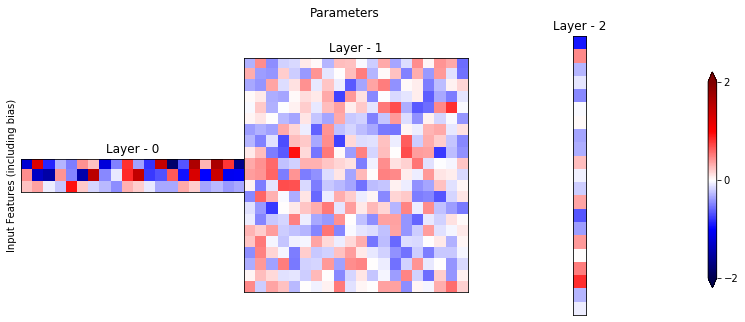

In [10]:
Net.make_plots()

In [14]:
Net.attrs

{'learning_rate': 0.01,
 'batch_size': 128,
 'nepochs': 500,
 'nchain': 5,
 'units': [20, 20],
 'scale': 0.0,
 'patience': 10,
 'min_delta': 1e-05,
 'global_seed': 123567,
 'model_dir': 'model/',
 'save_model': False}

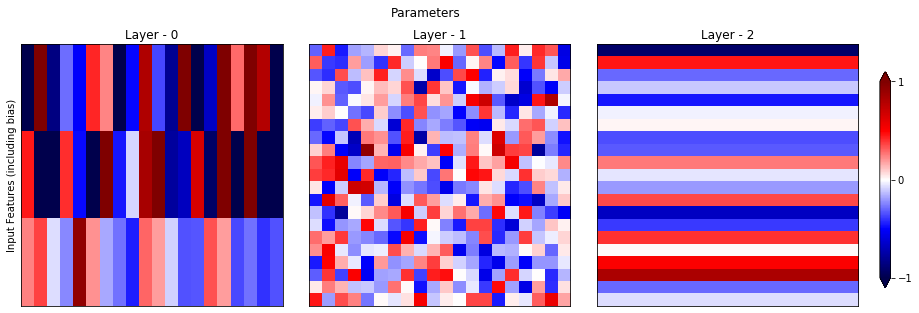

In [16]:
weights = Net.history[0].model.get_weights()
ncols   = len(weights) //2
fig, ax = plt.subplots(ncols=ncols, figsize=(5*ncols, 5))
fig.subplots_adjust(wspace=0.1, top=0.9)
fig.suptitle('Parameters')

for j in range(ncols):
    ax[j].set_title(f'Layer - {j}')
    extend = [0, 20, 0, 20]
    map1 = ax[j].imshow(np.row_stack([weights[2*j], weights[2*j+1]]), 
                 cmap=plt.cm.seismic, vmin=-1., vmax=1., extent=extend)
    #plt.setp(ax[j].get_xticklabels(), visible=False)
    #plt.setp(ax[j].get_yticklabels(), visible=False)
    ax[j].tick_params(
            axis='both',        # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            right=False,
            left=False,
            labelbottom=False) # labels along the bottom edge are off
    ax[j].set(yticks=[], xticks=[])        
    if j==0:ax[j].set(ylabel='Input Features (including bias)')
        
cax = plt.axes([.92, 0.2, 0.01, 0.6])
#cax = plt.axes([.25, 0.05, 0.5, 0.05]) ## goes w orientation='horizontal'
## colorbar label='parameters'
fig.colorbar(map1, cax=cax, 
             shrink=0.7, ticks=[-1, 0, 1], 
             extend='both')

        #.show()
#plt.colorbar()

In [37]:
# #             #
# #             # placeholders for the input errorbar and label
# #             y_  = tf.compat.v1.placeholder(tf.float32, [None, nclass])
# #             w   = tf.compat.v1.placeholder(tf.float32, [None, nclass])

# #             #
# #             # objective function
# #             mse = tf.compat.v1.losses.mean_squared_error(y_, y, weights=w)
# #             l2_loss = tf.compat.v1.losses.get_regularization_loss()
# #             mse_w_l2 = mse + l2_loss
# #             #
# #             # see https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer
# #             global_step = tf.Variable(0, name='global_step', trainable=False)
# #             optimizer   = tf.compat.v1.train.AdamOptimizer(learning_rate)
# #             train_step  = optimizer.minimize(mse_w_l2, global_step=global_step)            
# #             #print('chain ',ii)
# #             mse_min = 10000000.
# #             last_improvement = 0
# #             mse_list = []
# #             # 
# #             # initialize the NN
# #             #config = tf.ConfigProto()
# #             #config.intra_op_parallelism_threads = 1
# #             #config.inter_op_parallelism_threads = 1
# #             #sess = tf.InteractiveSession(config=config)
# #             sess = tf.compat.v1.InteractiveSession()
# #             tf.compat.v1.global_variables_initializer().run() 
# #             if verbose:iepoch = tqdm.tqdm(total=nepoch+1, desc='Epoch', position=1)
# #             for i in range(nepoch+1): # loop on training epochs
# #                 #
# #                 # save train & test MSE at each epoch
# #                 train_loss = mse.eval(feed_dict={x:train.X, y_:train.Y, w:train.W}) # June 7th 2:20pm - change self.train.X to train.X
# #                 valid_loss = mse.eval(feed_dict={x:valid.X, y_:valid.Y, w:valid.W})                                
# #                 #test_loss = mse.eval(feed_dict={x:test.X, y_:test.Y, w:test.W}) # to evaluate test MSE
# #                 mse_list.append([i, train_loss, valid_loss])
# #                 #mse_list.append([i, train_loss, valid_loss, test_loss])  # to save test MSE
# #                 #
# #                 #  Early Stopping
# #                 if (np.abs(valid_loss/mse_min -1.0) > tol) and (valid_loss < mse_min):
# #                     mse_min = valid_loss
# #                     last_improvement = 0
# #                 else:
# #                     last_improvement += 1
                
# #                 if last_improvement > patience:
# #                     #print("No improvement found during the {} last iterations at {}, stopping optimization!!".format(patience, i))
# #                     #print("stopping at {}".format(i))
# #                     break # stop training by early stopping
# #                 for k in range(nep): # loop on training unpdates
# #                     ji = k*batchsize
# #                     jj = np.minimum((k+1)*batchsize, train_size)                    
# #                     batch_xs, batch_ys, batch_ws = train.X[ji:jj], train.Y[ji:jj], train.W[ji:jj]   # use up to the last element
# #                     # train NN at each update
# #                     sess.run(train_step, feed_dict={x: batch_xs, y_:batch_ys, w:batch_ws})
# #                 if verbose:iepoch.update(1)
# #             #
            
# #             # save the final test MSE and prediction for each chain 
# #             y_mse, y_pred  = sess.run((mse,y),feed_dict={x: test.X, y_: test.Y, w:test.W})
# #             self.chain_y.append([ii, y_pred])
# #             self.epoch_MSEs.append([ii, y_mse, np.array(mse_list)])
# #             sess.close()
# #             tf.compat.v1.reset_default_graph()
# #             if verbose:ichain.update(1)
# #         # baseline model is the average of training label
# #         # baseline mse
# #         baselineY  = np.mean(train.Y)
# #         assert np.abs(baselineY) < 1.e-6, 'check normalization!'
# #         baseline_testmse  = np.mean(test.W  * test.Y**2)
# #         baseline_validmse = np.mean(valid.W * valid.Y**2)
# #         baseline_trainmse = np.mean(train.W * train.Y**2)
# #         #    
# #         self.optionsdic = {}
# #         self.optionsdic['baselineMSE']   = (baseline_trainmse, baseline_validmse, baseline_testmse)
# #         self.optionsdic['learning_rate'] = learning_rate
# #         self.optionsdic['batchsize']     = batchsize
# #         self.optionsdic['nepoch']        = nepoch
# #         self.optionsdic['nchain']        = nchain
# #         self.optionsdic['Units']         = Units
# #         self.optionsdic['scale']         = scale
# #         self.optionsdic['stats']         = {'xstat':self.Xstat, 'ystat':self.Ystat}

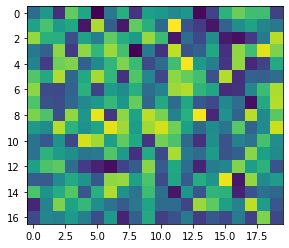

In [20]:
plt.imshow(NN.history[2].model.get_weights()[0])

In [ ]:
import tensorflow as tf                    # NN stuff
import tqdm
import numpy as np                         # numerical python 
import os

# imac branch
class preprocess(object):
    def __init__(self, datai, axfit=None):
        np.random.seed(12345)
        data   = datai.copy()      # copy input data
        np.random.shuffle(data)    # shuffle input data
        self.X = data['features']
        self.Y = data['label'][:,np.newaxis]
        self.P = data['hpind']
        self.W = data['fracgood'][:, np.newaxis]#**2
        if len(self.X.shape) == 1:
            self.X = self.X[:,np.newaxis]
        if axfit is not None:
            self.X = self.X[:, axfit]
            
        #self.Xs = None
        #self.Ys = None
        
    
class Netregression(object):
    """
        class for a general regression
    """
    def __init__(self, train, valid, test, axfit=None):
        # data (Traind, Testd) should have following attrs,
        #
        # features i.e.  X
        # label    i.e. Y = f(X) + noise ?
        # hpix     i.e. healpix indices to keep track of data
        # fracgood i.e. weight associated to each datapoint eg. pixel
        #
        # train
        self.train = preprocess(train, axfit)
        # test
        self.test  = preprocess(test,  axfit)
        # validation
        self.valid = preprocess(valid, axfit)
        
        #
        # one feature or more
        self.nfeatures = self.train.X.shape[1]
        
        
    def train_evaluate(self, learning_rate=0.001,
                       batchsize=100, nepoch=10, nchain=5,
                      Units=[10,10], tol=1.e-5, scale=0.0,
                       actfunc=tf.nn.relu, patience=10, verbose=False):
        #
        #from tensorflow.python.framework import ops

        nfeature = self.nfeatures
        #print('nfeature : ', nfeature)
        nclass   = 1            # for classification, you will have to change this
        #
        
        #
        #
        train = self.train
        valid = self.valid
        test  = self.test
        
        train_size = train.X.shape[0]
        #
        # using training label/feature mean and std
        # to normalize training/testing label/feature
        meanX      = np.mean(train.X, axis=0)
        stdX       = np.std(train.X, axis=0)
        meanY      = np.mean(train.Y, axis=0)
        stdY       = np.std(train.Y, axis=0)
        #
        # convert 0 stds to 1.0s
        assert np.all(stdX != 0.0)
        assert (stdY != 0.0)        
        #stdX[stdX==0.0] = 1.0

        
        self.Xstat = (meanX, stdX)
        self.Ystat = (meanY, stdY)
        
        train.X = (train.X - meanX) / stdX
        train.Y = (train.Y - meanY) / stdY
        test.X  = (test.X - meanX) / stdX
        test.Y  = (test.Y - meanY) / stdY
        valid.X = (valid.X - meanX) / stdX
        valid.Y = (valid.Y - meanY) / stdY
        #
        # compute the number of training updates
        if np.mod(train_size, batchsize) == 0:
            nep = (train_size // batchsize)
        else:
            nep = (train_size // batchsize) + 1
        #
        # initialize empty lists to store MSE 
        # and prediction at each training epoch for each chain
        self.epoch_MSEs = []
        self.chain_y     = []
        global_seed = 12345
        np.random.seed(global_seed)
        seeds = np.random.randint(0, 4294967295, size=nchain)

        if verbose:ichain = tqdm.tqdm(total=nchain, desc='Chain', position=0)
        for ii in range(nchain): # loop on chains
            #tf.set_random_seed(seeds[ii]) # set the seed
            tf.compat.v1.set_random_seed(seeds[ii])
            # set up the model x [input] -> y [output]
            x   = tf.compat.v1.placeholder(tf.float32, [None, nfeature])
            #
            # linear, one hidden layer or 2 hidden layers 
            # need to modify this if more layers are desired
            # tf.layers.dense works like f(aX+b) where f is activation
            if (len(Units) == 1) and Units[0]==0:    # linear
                kernel_init = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                y  = tf.layers.dense(x, units=nclass, activation=None, kernel_initializer=kernel_init,
                                    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=scale))
            elif len(Units) == 1 and Units[0]!=0: # 1 hidden layer
                kernel_init0 = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                kernel_init  = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[0])), seed=seeds[ii]) 
                y0 = tf.layers.dense(x,  units=Units[0], activation=actfunc, kernel_initializer=kernel_init0,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale)) 
                y  = tf.layers.dense(y0, units=nclass, activation=None, kernel_initializer=kernel_init,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale)) 
            elif len(Units) == 2:                                    # 2 hidden layers
                kernel_init0 = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                kernel_init1 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[0])), seed=seeds[ii]) 
                kernel_init  = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[1])), seed=seeds[ii]) 
                y0 = tf.layers.dense(x,  units=Units[0], activation=actfunc, kernel_initializer=kernel_init0,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y1 = tf.layers.dense(y0, units=Units[1], activation=actfunc, kernel_initializer=kernel_init1,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y  = tf.layers.dense(y1, units=nclass,   activation=None,  kernel_initializer=kernel_init,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
            elif len(Units) == 3:
                kernel_init0 = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                kernel_init1 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[0])), seed=seeds[ii]) 
                kernel_init2 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[1])), seed=seeds[ii]) 
                kernel_init  = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[2])), seed=seeds[ii]) 
                y0 = tf.layers.dense(x,  units=Units[0], activation=actfunc, kernel_initializer=kernel_init0,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y1 = tf.layers.dense(y0, units=Units[1], activation=actfunc,  kernel_initializer=kernel_init1,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y2 = tf.layers.dense(y1, units=Units[2], activation=actfunc,  kernel_initializer=kernel_init2,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y  = tf.layers.dense(y2, units=nclass,   activation=None,  kernel_initializer=kernel_init, 
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
            elif len(Units) == 4:
                kernel_init0 = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                kernel_init1 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[0])), seed=seeds[ii]) 
                kernel_init2 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[1])), seed=seeds[ii]) 
                kernel_init3 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[2])), seed=seeds[ii]) 
                kernel_init  = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[3])), seed=seeds[ii]) 
                y0 = tf.layers.dense(x,  units=Units[0], activation=actfunc, kernel_initializer=kernel_init0,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y1 = tf.layers.dense(y0, units=Units[1], activation=actfunc, kernel_initializer=kernel_init1,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y2 = tf.layers.dense(y1, units=Units[2], activation=actfunc, kernel_initializer=kernel_init2,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y3 = tf.layers.dense(y2, units=Units[3], activation=actfunc, kernel_initializer=kernel_init3,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y  = tf.layers.dense(y3, units=nclass,   activation=None, kernel_initializer=kernel_init,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
            else:
                raise ValueError('Units should be either None, [M], [M,N] ...')
            #
            # placeholders for the input errorbar and label
            y_  = tf.compat.v1.placeholder(tf.float32, [None, nclass])
            w   = tf.compat.v1.placeholder(tf.float32, [None, nclass])

            #
            # objective function
            mse = tf.compat.v1.losses.mean_squared_error(y_, y, weights=w)
            l2_loss = tf.compat.v1.losses.get_regularization_loss()
            mse_w_l2 = mse + l2_loss
            #
            # see https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer
            global_step = tf.Variable(0, name='global_step', trainable=False)
            optimizer   = tf.compat.v1.train.AdamOptimizer(learning_rate)
            train_step  = optimizer.minimize(mse_w_l2, global_step=global_step)            
            #print('chain ',ii)
            mse_min = 10000000.
            last_improvement = 0
            mse_list = []
            # 
            # initialize the NN
            #config = tf.ConfigProto()
            #config.intra_op_parallelism_threads = 1
            #config.inter_op_parallelism_threads = 1
            #sess = tf.InteractiveSession(config=config)
            sess = tf.compat.v1.InteractiveSession()
            tf.compat.v1.global_variables_initializer().run() 
            if verbose:iepoch = tqdm.tqdm(total=nepoch+1, desc='Epoch', position=1)
            for i in range(nepoch+1): # loop on training epochs
                #
                # save train & test MSE at each epoch
                train_loss = mse.eval(feed_dict={x:train.X, y_:train.Y, w:train.W}) # June 7th 2:20pm - change self.train.X to train.X
                valid_loss = mse.eval(feed_dict={x:valid.X, y_:valid.Y, w:valid.W})                                
                #test_loss = mse.eval(feed_dict={x:test.X, y_:test.Y, w:test.W}) # to evaluate test MSE
                mse_list.append([i, train_loss, valid_loss])
                #mse_list.append([i, train_loss, valid_loss, test_loss])  # to save test MSE
                #
                #  Early Stopping
                if (np.abs(valid_loss/mse_min -1.0) > tol) and (valid_loss < mse_min):
                    mse_min = valid_loss
                    last_improvement = 0
                else:
                    last_improvement += 1
                
                if last_improvement > patience:
                    #print("No improvement found during the {} last iterations at {}, stopping optimization!!".format(patience, i))
                    #print("stopping at {}".format(i))
                    break # stop training by early stopping
                for k in range(nep): # loop on training unpdates
                    ji = k*batchsize
                    jj = np.minimum((k+1)*batchsize, train_size)                    
                    batch_xs, batch_ys, batch_ws = train.X[ji:jj], train.Y[ji:jj], train.W[ji:jj]   # use up to the last element
                    # train NN at each update
                    sess.run(train_step, feed_dict={x: batch_xs, y_:batch_ys, w:batch_ws})
                if verbose:iepoch.update(1)
            #
            
            # save the final test MSE and prediction for each chain 
            y_mse, y_pred  = sess.run((mse,y),feed_dict={x: test.X, y_: test.Y, w:test.W})
            self.chain_y.append([ii, y_pred])
            self.epoch_MSEs.append([ii, y_mse, np.array(mse_list)])
            sess.close()
            tf.compat.v1.reset_default_graph()
            if verbose:ichain.update(1)
        # baseline model is the average of training label
        # baseline mse
        baselineY  = np.mean(train.Y)
        assert np.abs(baselineY) < 1.e-6, 'check normalization!'
        baseline_testmse  = np.mean(test.W  * test.Y**2)
        baseline_validmse = np.mean(valid.W * valid.Y**2)
        baseline_trainmse = np.mean(train.W * train.Y**2)
        #    
        self.optionsdic = {}
        self.optionsdic['baselineMSE']   = (baseline_trainmse, baseline_validmse, baseline_testmse)
        self.optionsdic['learning_rate'] = learning_rate
        self.optionsdic['batchsize']     = batchsize
        self.optionsdic['nepoch']        = nepoch
        self.optionsdic['nchain']        = nchain
        self.optionsdic['Units']         = Units
        self.optionsdic['scale']         = scale
        self.optionsdic['stats']         = {'xstat':self.Xstat, 'ystat':self.Ystat}
            
            
    def savez(self, indir='./', name='regression_2hl_5chain_10epoch'):
        output = {}
        output['train']      = self.train.P, self.train.X, self.train.Y, self.train.W 
        output['test']       = self.test.P, self.test.X, self.test.Y, self.test.W 
        output['valid']      = self.valid.P, self.valid.X, self.valid.Y, self.valid.W         
        output['epoch_MSEs'] = self.epoch_MSEs
        output['chain_y']    = self.chain_y
        output['options']    = self.optionsdic
        if indir[-1] != '/':
            indir += '/'
        if not os.path.exists(indir):
            os.makedirs(indir)
        #if not os.path.isfile(indir+name+'.npz'):   # write w a new name
        np.savez(indir+name, output)
        #else:
        #    print("there is already a file!")
        #    name = name+''.join(time.asctime().split(' '))
        #    np.savez(indir+name, output)
        print('output is saved as {} under {}'.format(name, indir))